<a href="https://colab.research.google.com/github/thiagonoobre/Modelo_de_Classificacao_para_Previsao_de_Diabetes/blob/main/Modelo_de_Classifica%C3%A7%C3%A3o_para_Previs%C3%A3o_de_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 Projeto de Diagnóstico de Diabetes com Regressão Logística

A detecção precoce de diabetes é crucial para a gestão eficaz da doença e a prevenção de complicações graves. Neste projeto, exploramos o conjunto de dados `Pima Indians Diabetes Database` com o objetivo de construir um modelo preditivo de **Regressão Logística** capaz de identificar indivíduos propensos a desenvolver diabetes com base em diversas variáveis clínicas. O desenvolvimento deste modelo visa fornecer uma ferramenta auxiliar para o diagnóstico, contribuindo para intervenções médicas mais rápidas e personalizadas. O notebook detalha todas as etapas, desde a análise exploratória e tratamento de dados até a avaliação aprofundada do desempenho do modelo.



## 1\. Introdução
- **Problema**: Diagnóstico de diabetes precoce com base em dados clínicos.
- **Objetivo**: Criar um modelo preditivo para auxiliar na decisão médica.
- **Modelo escolhido**: Regressão Logística.


Referências e Fontes
1. Dataset: [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
2. Scikit-learn Documentation


## 2\. Carregamento e Entendimento dos Dados
> Nesta etapa, carregamos o dataset e visualizamos suas principais características iniciais.


In [1]:
import kagglehub
mragpavank_diabetes_path = kagglehub.dataset_download('mragpavank/diabetes')

print('Data source import complete.')

Data source import complete.


In [2]:
mragpavank_diabetes_path

'/kaggle/input/diabetes'

### 2.1. imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [4]:
df = pd.read_csv('/kaggle/input/diabetes/diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.Outcome.value_counts()

,count
Outcome,
0,500
1,268


In [7]:
df.shape

(768, 9)

## 3\. Análise Exploratória de Dados (EDA)


Exploramos as distribuições das variáveis, outliers e a proporção das classes alvo (`Outcome`).

### 3.1. Distribuição da Variável Target (Outcome)


In [8]:
procentagem = (df.Outcome.mean() * 100).round(2)
procentagem

np.float64(34.9)

/tmp/ipython-input-9-3562178247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette="Set2")


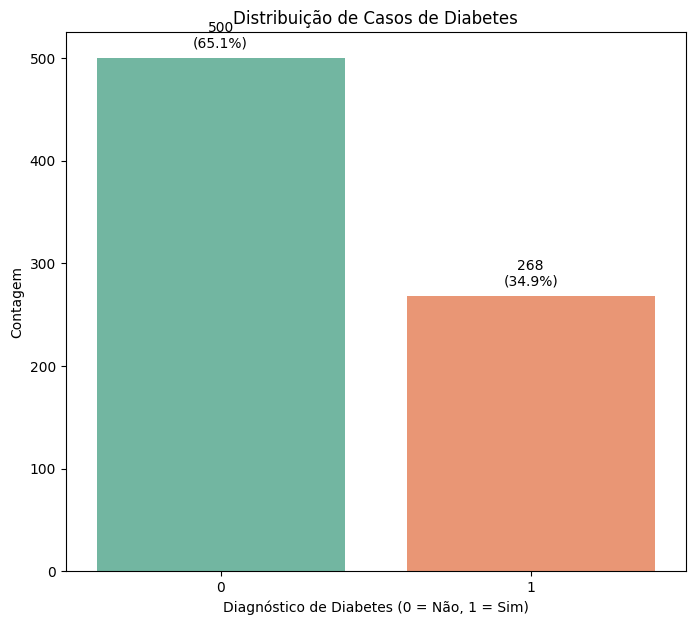

In [9]:
outcome_dist = df['Outcome'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 7))
sns.countplot(x='Outcome', data=df, palette="Set2")
plt.title('Distribuição de Casos de Diabetes')
plt.xlabel('Diagnóstico de Diabetes (0 = Não, 1 = Sim)')
plt.ylabel('Contagem')
for i, v in enumerate(df['Outcome'].value_counts()):
    plt.text(i, v + 10, f'{v}\n({outcome_dist[i]:.1f}%)', ha='center')
plt.show()

> Nossa base de dados não está muito **desequilibrada**, isso é importante para saber quais técnicas de predição devemos se basea para estrair os melhores insighits.

### 3.2. Estatísticas Descritivas

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [11]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


> Como podemos ver no comando acima não tem valores missing no dataset, mas será preciso analisar melhor para entender melhor o dataset.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


> Como podemos ver do `describe` acima, Temos valores 0 nos minimos da colunas *Pregnancies*, *Glucose*, *BloodPressure*, *SkinThickness*, *Insulin* e *BMI*. Muito possível que os dados missing esteja com o valor 0 (zero).

### 3.3 Análise de Valores Ausentes/Zero

/tmp/ipython-input-13-2190285357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zero_percent.index, y=zero_percent.values, palette="viridis")


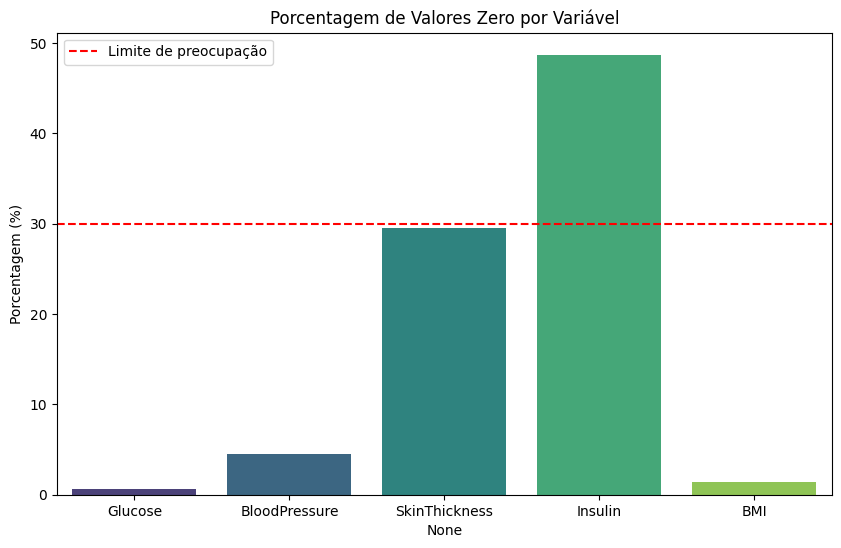

In [13]:
# Identificar zeros em colunas onde não são biologicamente plausíveis
zero_counts = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].apply(lambda x: (x == 0).sum())
zero_percent = (zero_counts / len(df) * 100).round(2)

plt.figure(figsize=(10, 6))
sns.barplot(x=zero_percent.index, y=zero_percent.values, palette="viridis")
plt.title('Porcentagem de Valores Zero por Variável')
plt.ylabel('Porcentagem (%)')
plt.axhline(y=30, color='r', linestyle='--', label='Limite de preocupação')
plt.legend()
plt.show()

In [14]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].apply(lambda x: (x == 0).sum())


,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


In [15]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].apply(lambda x: ((x == 0).sum() / len(df)).round(4) * 100)

,0
Pregnancies,14.45
Glucose,0.65
BloodPressure,4.56
SkinThickness,29.56
Insulin,48.70
BMI,1.43


> A análise inicial revela um problema significativo: os comandos executados quantifica os **valores zero** nas colunas onde eles são **biologicamente implausíveis**. Dada a nossa base de dados de **768 linhas**, a coluna **Insulin** apresenta um desafio particular, com **374 valores zero**. Isso representa **48,7%** dos dados dessa coluna, impactando diretamente a qualidade e a confiabilidade de nossas análises.


### 3.4. Identificação de Outliers

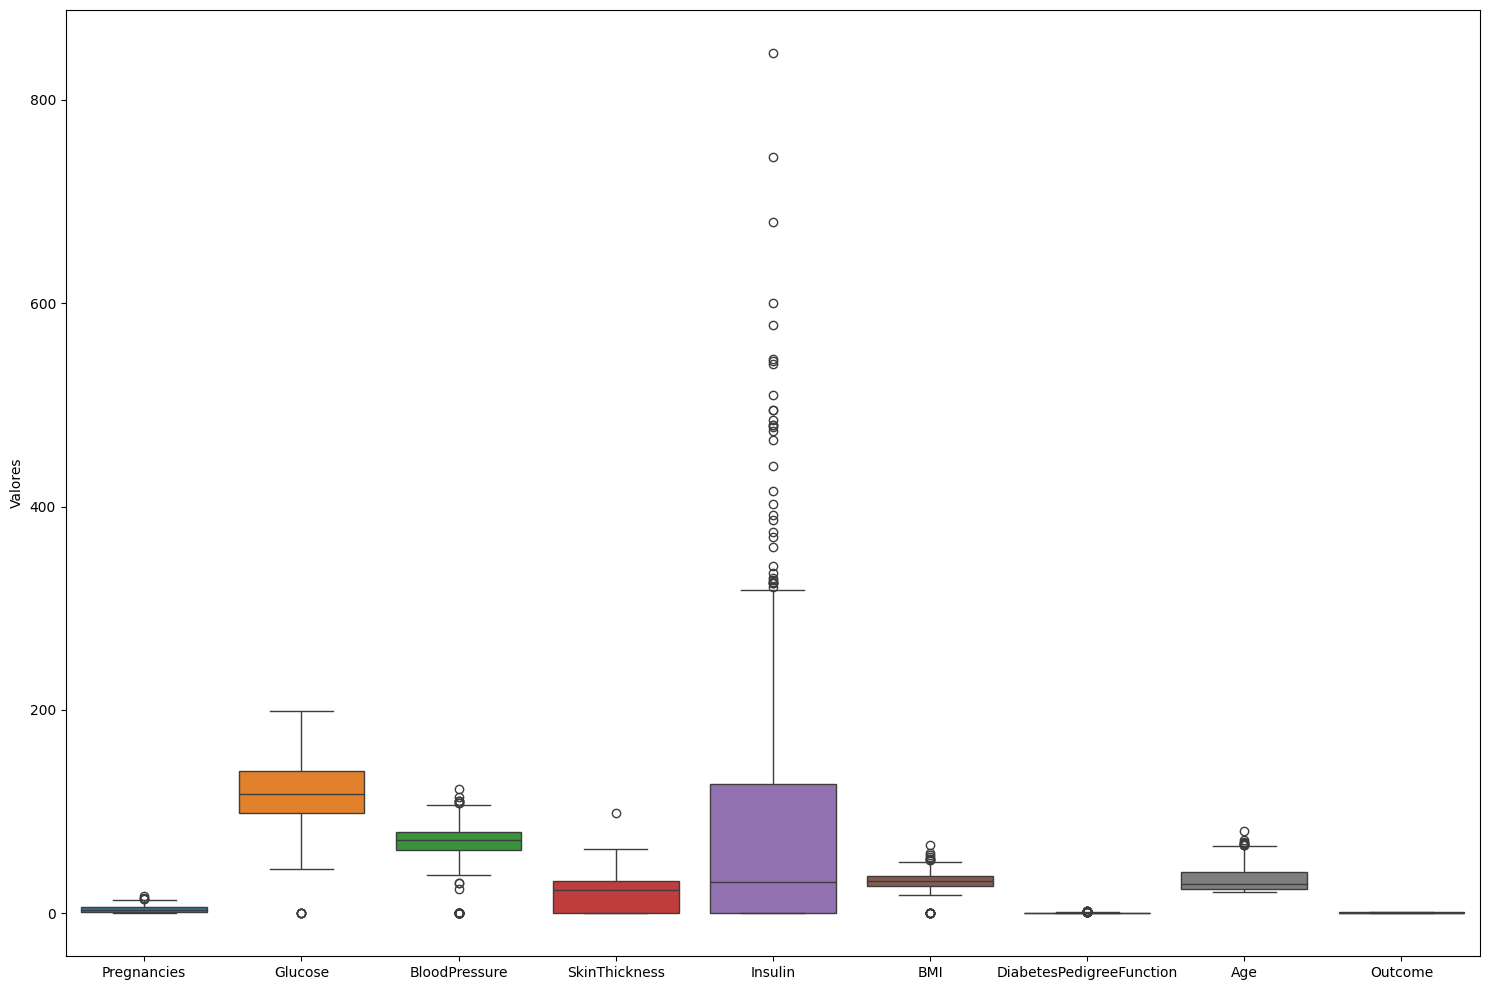

In [16]:
plt.figure(figsize=(15, 10))

sns.boxplot(data=df)
plt.ylabel('Valores')
plt.grid(False) # Opcional: remover a grade para uma aparência mais limpa
plt.tight_layout() # Ajusta o layout para evitar sobreposição de rótulos
plt.show()

Como podemos ver acima o nosso dataframe tem *Outliers*. Importante verificar esse ponto já que as técnicas de deveremos usar precisa evitar ditorções dentro do nosso dataframe.

## 5\. Tratamento de Dados
Substituímos valores '0' inválidos por `NaN` e aplicamos imputações apropriadas. Também realizamos a padronização das variáveis numéricas.


>  *Glucose*, *BloodPressure* e *BMI*

- Pouca ou moderada quantidade de missing.
- Imputação com **mediana** (robusta contra outliers)
- **Justificativa**: Preservar o volume de dados e evitar distorção com a média (especialmente se a distribuição for assimétrica).

In [17]:
for col in ['Glucose', 'BloodPressure', 'BMI']:
    median = df[df[col] != 0][col].median()
    df[col] = df[col].replace(0, median)


> *SkinThickness* e *Insulin*

- Imputação com KNN
- **Justificativa**: KNN leva em conta outras features e pode manter a correlação com o perfil do paciente, útil para variáveis fisiológicas.
- **Ponto de Atenção**: a padronização prévia é essencial para resultados confiáveis com KNNImputer.

In [18]:
# 1. Cópia segura dos dados já tratados
df_temp = df.copy()

# 2. Substituir 0 por NaN nas colunas-alvo do KNN
cols_missing = ['SkinThickness', 'Insulin']
df_temp[cols_missing] = df_temp[cols_missing].replace(0, np.nan)

# 3. Selecionar colunas base (JÁ TRATADAS + COM MISSING)
cols_base = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# 4. Padronizar mantendo os NaNs
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_temp[cols_base]),
                           columns=cols_base, index=df_temp.index)

# 5. Aplicar KNNImputer nos dados com NaN preservados
imputer = KNNImputer(n_neighbors=5)
imputed_scaled = imputer.fit_transform(scaled_data)

# 6. Reverter a padronização
imputed_data = scaler.inverse_transform(imputed_scaled)
df_imputed = pd.DataFrame(imputed_data, columns=cols_base, index=df_temp.index)

# 7. Atualizar APENAS as colunas-alvo
df['SkinThickness'] = df_imputed['SkinThickness']
df['Insulin'] = df_imputed['Insulin']

In [19]:
print("\nDepois da imputação:")
print(df[['SkinThickness','Insulin']].describe().round(2))


Depois da imputação:
       SkinThickness  Insulin
count         768.00   768.00
mean           29.05   154.09
std             9.46    98.10
min             7.00    14.00
25%            23.00    89.30
50%            29.00   130.00
75%            35.00   193.70
max            99.00   846.00


In [20]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].apply(lambda x: (x == 0).sum())


,0
Pregnancies,111
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0


## 6\. Análise de Correlações e Verificação de Multicolinearidade

Utilizamos o Fator de Inflação da Variância (VIF) para verificar relações colineares entre variáveis preditoras.


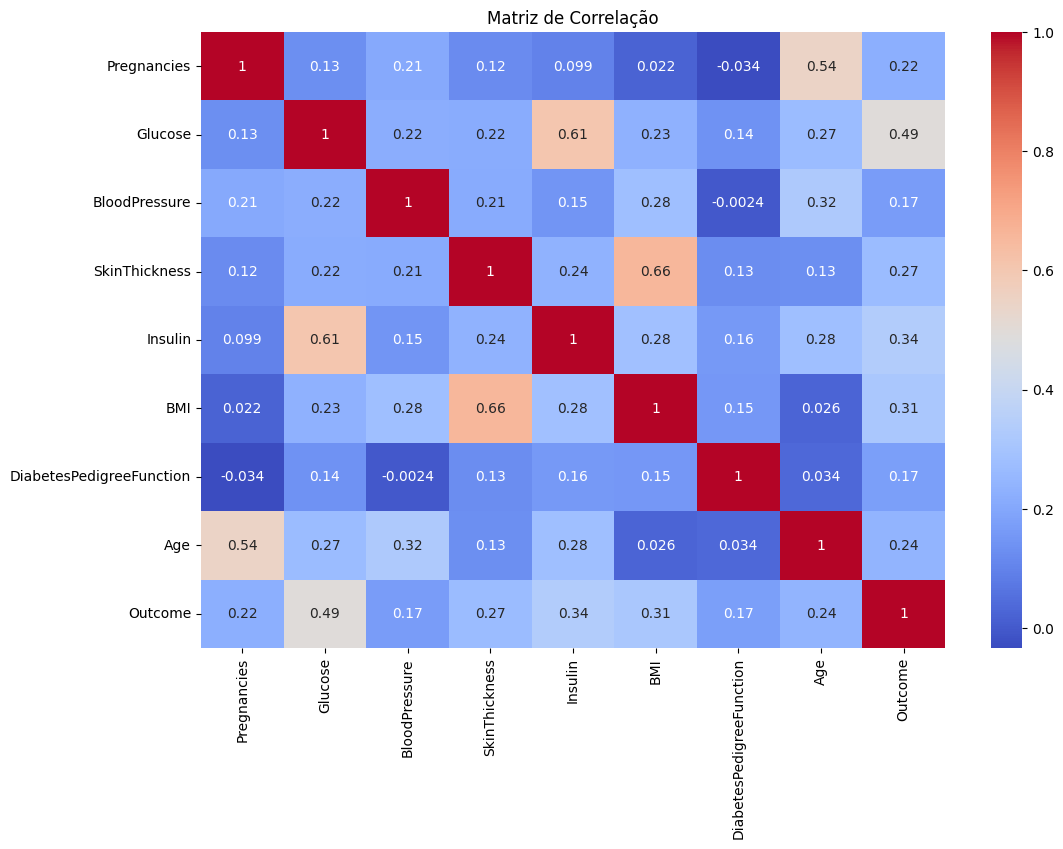

In [21]:
plt.figure(figsize=(12, 8))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

Como podemos verificar temos uma corelação moderada nas variaveis  `SkinThickness` × `BMI` e `Insulin` × `Glucose`.

Nesse caso:

* `SkinThickness` × `BMI` → **0.66** → moderada-alta
* `Insulin` × `Glucose` → **0.61** → moderada

**Conclusão preliminar**: não indicam multicolinearidade severa, mas merecem ser investigadas com **VIF**, pois a correlação bivariada nem sempre revela a relação multivariada oculta.



In [22]:
# Selecionar colunas preditoras
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Adicionar constante (intercepto)
X_const = add_constant(X)

# Calcular VIF para cada variável
vif_data = pd.DataFrame()
vif_data["Variável"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

print(vif_data)

                   Variável        VIF
0                     const  57.110141
1               Pregnancies   1.443931
2                   Glucose   1.647629
3             BloodPressure   1.243468
4             SkinThickness   1.829784
5                   Insulin   1.706962
6                       BMI   1.979025
7  DiabetesPedigreeFunction   1.049501
8                       Age   1.667845


> O resultado do VIF confirma que não há multicolinearidade preocupante entre as variáveis do seu modelo.

- **Todos os VIFs < 2**, o que está bem abaixo do limiar de preocupação (geralmente 5 ou 10).

- O intercepto (`const`) naturalmente tem um VIF alto e **deve ser ignorado** nessa análise.

## 7\. Divisão dos Dados em Treino e Teste
Separamos os dados em conjuntos de treino e teste utilizando a função `train_test_split`, preservando a proporção das classes.


In [23]:
# 1. Separar features e target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 2. Dividir dados ANTES da padronização
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 8\. Construção do Pipeline e Treinamento do Modelo
Criamos um pipeline com `RobustScaler` e `LogisticRegression` e treinamos com os dados de treino.


In [24]:
# 3. Criar pipeline com padronização e modelo
model = make_pipeline(
    RobustScaler(),  # Apenas para features numéricas
    LogisticRegression(penalty='l2', max_iter=500, random_state=42)
)

# 4. Treinar usando APENAS dados de treino
model.fit(X_train, y_train)


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

> Depois da parte de entender os dados com a aplicação da analise exploraria, iniciaremos o processo de aplicação do modelo

- **Métodos de Padronização**: Usareos o RobustScaler já que os dados possuim **outliers**.
- **Data Leakage**: Não usaremos **Padronização** com o conjunto completo.
- **Prevenção de Overfitting**: Usaremos no modelo o `penalty='l2'` para ajudar o modelo a generalizar melhor para novos dados.

## 9\. Avaliação Inicial do Modelo
Avaliamos a acurácia do modelo nos conjuntos de treino e teste utilizando o threshold padrão de 0.5.


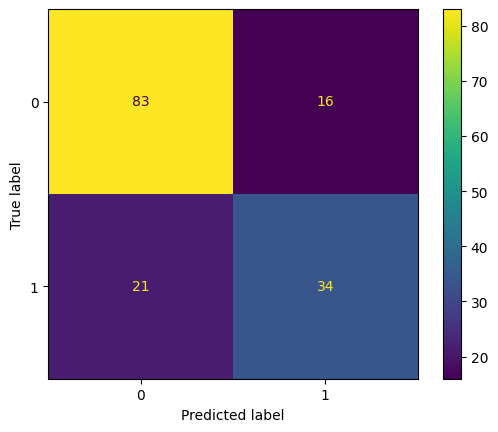

In [25]:
# Previsões do modelo
y_pred = model.predict(X_test)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Ao analisar a Matriz de Confusão, obtemos uma visão mais detalhada e crítica do desempenho do modelo em suas previsões. Neste caso, observamos **83 Verdadeiros Positivos (TP)**, que representam as instâncias em que o modelo previu corretamente 'diabetes', e o paciente de fato possuía a condição.

No entanto, há dois pontos cruciais que exigem nossa atenção:

1.  **Falsos Positivos (FP):** Identificamos **16 casos** em que o modelo previu 'diabetes', mas o paciente era, na realidade, saudável. Embora estes sejam 'alarmes falsos', eles podem gerar preocupação desnecessária no indivíduo e potencialmente levar a exames e custos adicionais.

2.  **Falsos Negativos (FN):** Este é o ponto de maior preocupação. Registramos **21 casos** em que o modelo previu 'saudável', mas o paciente, na verdade, tinha diabetes. Um Falso Negativo neste contexto é um **erro grave**, pois implica que um paciente com a condição não será diagnosticado e, consequentemente, **não receberá o tratamento necessário**, o que pode ter sérias consequências para a saúde a longo prazo.

Apesar dos **Verdadeiros Negativos (TN)**, que representam os casos em que o modelo previu 'saudável' corretamente e o paciente era saudável, é vital ponderar o impacto dos Falsos Negativos e Falsos Positivos ao determinar a adequação do modelo para aplicações clínicas.


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



In [27]:
# Especificidade: TN / (TN + FP)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"Especificidade: {specificity:.2f}")

Especificidade: 0.84


Para o corte padrão de probabilidade 0.5, interpretamos:

- **Precision:** 0.68 >> De todos os pacientes que o modelo classificou como diabéticos, 68% realmente estavam diabéticos.<br>
- **Sensibilidade/Recall:** 0.62 >> De todos os pacientes realmente estavam diabéticos, o modelo classificou como diabéticos apenas 62%.<br>
- **Especificidade:** 0.84 >> De todos os pacientes que **não** estavam diabéticos, o modelo classificou como não diabéticos 84%.<br>

**A sensibilidade (Recall) é a métrica mais crítica** por duas razões fundamentais:

1. **Consequências graves de falsos negativos**:  
   - Um falso negativo significa que um paciente diabético não receberá tratamento  
   - Pode levar a complicações como cegueira, falência renal, amputações e morte

2. **Natureza progressiva da doença**:  
   - Diagnóstico precoce permite intervenções que podem prevenir complicações  
   - Não diagnosticar é mais prejudicial que um alarme falso

**Métrica secundária crucial**: AUC (especialmente a área na região de alta sensibilidade)



## 10\. Ajuste de Threshold de Decisão



Perfeito! Ajustar o **threshold de decisão** é uma estratégia poderosa para **aumentar o Recall**, principalmente em problemas como **diagnóstico de diabetes**, onde é **melhor errar por excesso (FP) do que por omissão (FN)**.



In [28]:
# Obter probabilidades de predição
y_proba = model.predict_proba(X_test)[:, 1]

In [29]:
thresholds = np.arange(0.0, 1.01, 0.05)
for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {t:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Threshold: 0.00 | Precision: 0.36 | Recall: 1.00 | F1: 0.53
Threshold: 0.05 | Precision: 0.38 | Recall: 1.00 | F1: 0.56
Threshold: 0.10 | Precision: 0.45 | Recall: 1.00 | F1: 0.62
Threshold: 0.15 | Precision: 0.48 | Recall: 0.95 | F1: 0.64
Threshold: 0.20 | Precision: 0.51 | Recall: 0.89 | F1: 0.65
Threshold: 0.25 | Precision: 0.54 | Recall: 0.82 | F1: 0.65
Threshold: 0.30 | Precision: 0.55 | Recall: 0.78 | F1: 0.65
Threshold: 0.35 | Precision: 0.58 | Recall: 0.71 | F1: 0.64
Threshold: 0.40 | Precision: 0.60 | Recall: 0.71 | F1: 0.65
Threshold: 0.45 | Precision: 0.65 | Recall: 0.67 | F1: 0.66
Threshold: 0.50 | Precision: 0.68 | Recall: 0.62 | F1: 0.65
Threshold: 0.55 | Precision: 0.76 | Recall: 0.62 | F1: 0.68
Threshold: 0.60 | Precision: 0.80 | Recall: 0.58 | F1: 0.67
Threshold: 0.65 | Precision: 0.81 | Recall: 0.53 | F1: 0.64
Threshold: 0.70 | Precision: 0.79 | Recall: 0.49 | F1: 0.61
Threshold: 0.75 | Precision: 0.86 | Recall: 0.33 | F1: 0.47
Threshold: 0.80 | Precision: 0.89 | Reca

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


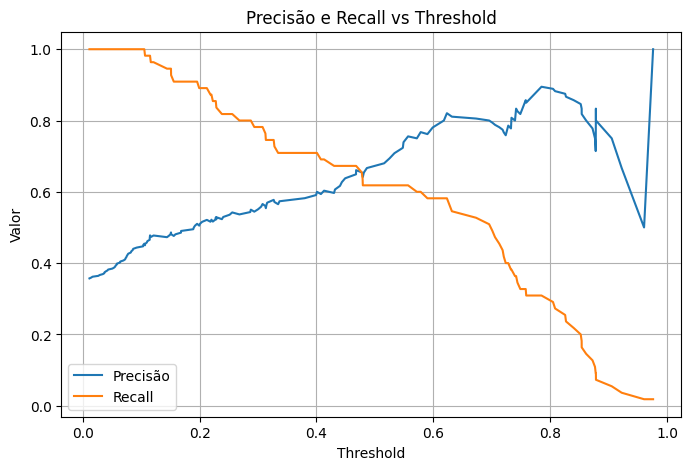

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precisão')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Precisão e Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()


> Com base no equilíbrio Recall × F1 × Precision

Threshold = **0.20**<br>
Recall = 0.89<br>
Precision = 0.51<br>
F1-Score = 0.65<br>

Justificativa:

- Mantém **alto recall (89%)**, o que reduz drasticamente os Falsos Negativos (misses de diabetes).

- Ainda tem **boa precisão (51%)**: metade dos diagnósticos positivos são corretos.

- **F1 equilibrado** (0.65), igual ao threshold padrão (0.5), mas com muito mais Recall!

> Matriz de Confusão com Threshold de 0.5

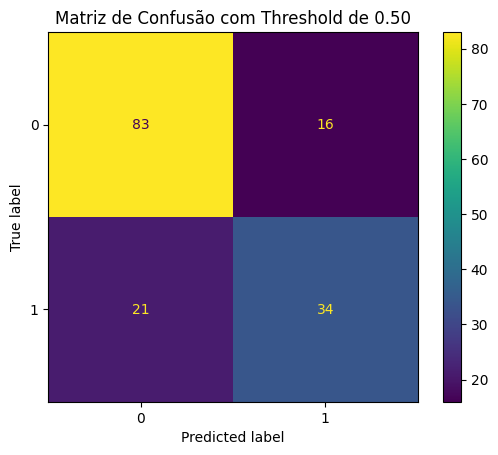

In [41]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão com Threshold de 0.50')
# Salva a imagem como SVG (ótimo para vetores)
plt.savefig('Matriz_Confusão_Threshold05.png', bbox_inches='tight')

> Matriz de Confusão com Threshold de 0.2

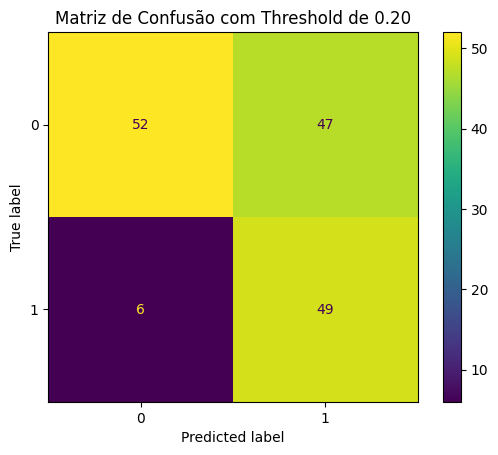

In [40]:
# aplicar na prática
threshold_otimo = 0.20
y_pred_ajustado = (y_proba >= threshold_otimo).astype(int)
cm2 = confusion_matrix(y_test, y_pred_ajustado)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
plt.title('Matriz de Confusão com Threshold de 0.20')
plt.savefig('Matriz_Confusão_Threshold02.png', bbox_inches='tight')

A nova Matriz de Confusão apresenta uma configuração que reflete um ajuste nas prioridades do modelo, particularmente notável ao comparar com os resultados anteriores.

Observa-se que conseguimos **reduzir significativamente os Falsos Negativos (FN) de 21 para 6 casos.** Esta diminuição é um avanço crucial, especialmente no contexto de diagnóstico de diabetes, pois significa que o modelo está falhando menos em identificar pacientes que realmente possuem a condição. A minimização dos Falsos Negativos é frequentemente prioritária em problemas médicos, dada a gravidade de um não-diagnóstico.

No entanto, essa melhoria veio com um *trade-off*. Os **Falsos Positivos (FP) aumentaram de 16 para 47 casos.** Isso indica que, para garantir que menos casos de diabetes sejam perdidos, o modelo agora tende a classificar mais indivíduos saudáveis como diabéticos. Embora sejam 'alarmes falsos' que podem gerar ansiedade e custos adicionais com exames desnecessários, essa situação é geralmente preferível a um Falso Negativo no cenário de saúde.

Consequentemente, o número de **Verdadeiros Positivos (TP) diminuiu de 83 para 49 casos.** Esta redução nos diagnósticos corretos de diabetes pode parecer preocupante à primeira vista. No entanto, é importante entender que essa mudança está intrinsecamente ligada ao aumento dos Falsos Positivos. Se o modelo está predizendo 'diabetes' para mais pessoas, algumas delas (os 47 FPs) são classificadas incorretamente, 'roubando' da contagem de acertos para a classe positiva que antes era mais precisa para os verdadeiros positivos.

Em resumo, a nova matriz de confusão sugere que o modelo foi ajustado para ser mais sensível na detecção de diabetes, priorizando a **Sensibilidade (Recall)** à custa da **Precisão** e de alguns Verdadeiros Positivos na classe 1. A escolha de qual cenário é mais desejável dependerá diretamente da gravidade das consequências de cada tipo de erro para a aplicação específica, mas, em contextos de saúde, a minimização de Falsos Negativos é frequentemente a meta primária.

## 11\. Métricas Avançadas e Visualizações
Incluímos a Matriz de Confusão, Curvas ROC, AUC, Precisão-Recall e o estatístico KS para aprofundar a avaliação do modelo.


In [33]:
print(classification_report(y_test, y_pred_ajustado))

              precision    recall  f1-score   support

           0       0.90      0.53      0.66        99
           1       0.51      0.89      0.65        55

    accuracy                           0.66       154
   macro avg       0.70      0.71      0.66       154
weighted avg       0.76      0.66      0.66       154



O modelo demonstra uma estratégia clara de **priorizar a Sensibilidade (Recall) para a classe 'diabetes' (0.89)**. Isso é altamente desejável em um cenário de diagnóstico de saúde, onde evitar Falsos Negativos (pacientes com diabetes não diagnosticados) é de suma importância para o tratamento precoce.

No entanto, essa alta sensibilidade para a classe 'diabetes' resultou em uma **precisão mais baixa (0.51)** para essa mesma classe e um **recall mais baixo (0.53) para a classe 'não diabetes'**, levando a um número considerável de Falsos Positivos.

A decisão de aceitar este *trade-off* (mais alarmes falsos para garantir que poucos casos reais sejam perdidos) é frequentemente justificada em aplicações médicas críticas. O F1-Score geral e a acurácia de 0.66 indicam que, embora o modelo esteja longe da perfeição, ele está funcionando de acordo com essa prioridade de detecção de diabetes.

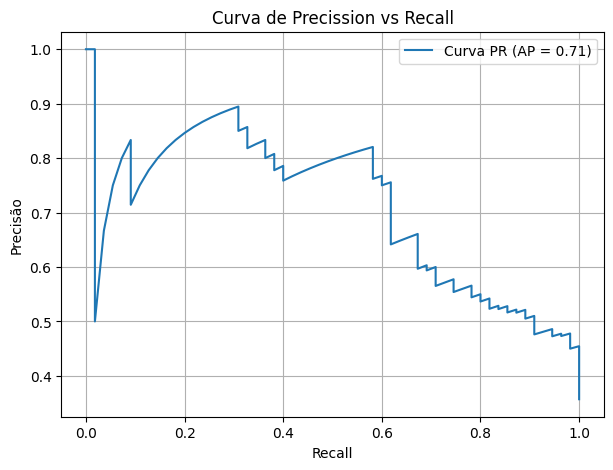

In [42]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'Curva PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precission vs Recall')
plt.grid()
plt.legend()
plt.savefig('Curva_Precisão_Recall.png', bbox_inches='tight')
plt.show()


- **A área sob a curva (Average Precision)** resume o desempenho:

- **AP > 0.7**: ótimo em problemas de saúde.

- Permite avaliar se vale a pena sacrificar precisão para capturar mais positivos (Recall).

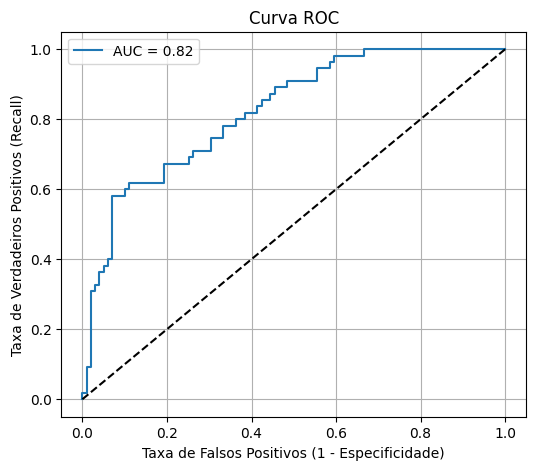

Área sob a curva ROC (AUC): 0.82


In [43]:
# Probabilidades para a classe positiva (diabetes)
y_proba = model.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Linha aleatória
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.savefig('Curva_ROC_AUC.png', bbox_inches='tight')
plt.show()

print(f"Área sob a curva ROC (AUC): {auc_score:.2f}")

> AUC mede a capacidade do modelo de distinguir entre classes. Quanto maior, melhor a discriminação. Um AUC de 0.82 podemos considerar Excelente

In [36]:
# Separar probabilidades por classe real
proba_1 = y_proba[y_test == 1]  # diabéticos
proba_0 = y_proba[y_test == 0]  # não diabéticos

# Estatística KS
ks_stat, ks_p = stats.ks_2samp(proba_1, proba_0)
print(f"KS: {ks_stat:.2f}")

KS: 0.51


> O KS mede a separação máxima entre as distribuições de probabilidade das duas classes. Um KS de 0.51 podemos considerar uma boa separação

In [37]:
# Acessar o estimador final do pipeline (LogisticRegression)
logistic_reg_model = model.named_steps['logisticregression']

# Obter os coeficientes
coefficients = logistic_reg_model.coef_[0] # [0] pois LogisticRegression.coef_ é um array 2D para multiclasse, mas 1D para binário.
intercept = logistic_reg_model.intercept_[0]

# Criar um DataFrame para visualização clara
# As colunas de X são as features originais
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Opcional: Calcular Odds Ratio
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])

# Ordenar por valor absoluto do coeficiente para ver as mais importantes
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("--- Coeficientes do Modelo de Regressão Logística (após RobustScaler) ---")
print(coef_df[['Feature', 'Coefficient', 'Odds Ratio']].round(4))

print(f"\nIntercepto (constante): {intercept:.4f}")


--- Coeficientes do Modelo de Regressão Logística (após RobustScaler) ---
                    Feature  Coefficient  Odds Ratio
1                   Glucose       1.3948      4.0342
5                       BMI       0.8449      2.3277
7                       Age       0.5622      1.7545
0               Pregnancies       0.3219      1.3797
6  DiabetesPedigreeFunction       0.2206      1.2468
2             BloodPressure      -0.1870      0.8295
3             SkinThickness       0.1448      1.1559
4                   Insulin      -0.0870      0.9167

Intercepto (constante): -1.3027


1.  **`Glucose` (Glicose):**

      * **Coeficiente: 1.3948 (positivo e o maior em magnitude)**.
      * **Odds Ratio: 4.0342**.
      * **Interpretação:** A glicose é a feature mais influente. Um aumento em seu valor (mantendo outras constantes) **aumenta fortemente a chance de ter diabetes**. Para cada unidade de aumento na glicose (após ser escalada pelo RobustScaler), as chances de ter diabetes são multiplicadas por aproximadamente 4.03. Isso faz sentido clinicamente, pois níveis elevados de glicose são um indicador direto de diabetes.

2.  **`BMI` (Índice de Massa Corporal):**

      * **Coeficiente: 0.8449 (positivo)**.
      * **Odds Ratio: 2.3277**.
      * **Interpretação:** Um BMI mais alto está fortemente associado a um aumento nas chances de diabetes, o que é consistentemente observado na medicina.

3.  **`Age` (Idade):**

      * **Coeficiente: 0.5622 (positivo)**.
      * **Odds Ratio: 1.7545**.
      * **Interpretação:** Pessoas mais velhas têm chances significativamente maiores de ter diabetes, o que é um fator de risco conhecido.

4.  **`BloodPressure` (Pressão Sanguínea):**

      * **Coeficiente: -0.1870 (negativo, mas muito próximo de zero)**.
      * **Odds Ratio: 0.8295**.
      * **Interpretação:** Este coeficiente é muito pequeno e negativo, indicando que a pressão sanguínea, **neste modelo e após a escala**, tem uma relação muito fraca, ou quase neutra/ligeiramente inversa, com a probabilidade de diabetes. Clinicamente, a pressão alta está associada à diabetes, mas talvez em conjunto com outras features sua contribuição individual direta seja atenuada neste modelo específico ou o range de valores na amostra não tenha um impacto tão grande.

5.  **`Insulin` (Insulina):**
    * **Coeficiente: -0.0870 (Negativo)**
    * **Odds Ratio: 0.9167**
    * **Preocupação:** Clinicamente, níveis elevados de insulina (especialmente em jejum ou após teste de tolerância à glicose, que é o que geralmente se espera no dataset Pima) estão **fortemente associados à resistência à insulina e, consequentemente, ao diabetes tipo 2**. Um coeficiente negativo aqui é **contraintuitivo** ou, no mínimo, surpreendente.


## 12\. Conclusão



A jornada de construção e avaliação do modelo de Regressão Logística para o diagnóstico de diabetes no dataset Pima Indians revelou um desempenho promissor e um *trade-off* estratégico importante.

Após o tratamento cuidadoso dos dados (incluindo a imputação dos valores 'zero' e a verificação de multicolinearidade), o modelo foi treinado e avaliado com foco nas necessidades clínicas.

A decisão de ajustar o limiar de classificação para **0.2** foi fundamental e estratégica. Essa mudança resultou em uma **redução significativa dos Falsos Negativos (FNs) de 21 para apenas 6 casos**. Essa minimização de falhas no diagnóstico de pacientes com diabetes é crucial em um contexto médico, onde as consequências de um não-diagnóstico podem ser graves. Essa prioridade se reflete na **Sensibilidade (Recall) notavelmente alta de 0.89 para a classe 'diabetes'**.

Como esperado, essa alta sensibilidade acarretou um aumento nos **Falsos Positivos (FPs) de 16 para 47 casos** e uma **diminuição na Precisão para a classe 'diabetes' (0.51)**. Isso indica que, embora o modelo seja mais propenso a identificar diabéticos, ele também gera mais "alarmes falsos" em indivíduos saudáveis. Contudo, em cenários de saúde, o custo de um Falso Negativo geralmente supera o de um Falso Positivo.

A avaliação com métricas independentes do limiar solidifica o potencial do modelo:

* A **Área Sob a Curva ROC (AUC) de 0.82** indica uma boa capacidade discriminatória geral do modelo, sugerindo que ele consegue distinguir razoavelmente bem entre pacientes com e sem diabetes em diferentes limiares. Um valor acima de 0.8 é geralmente considerado um bom desempenho.
* A **Área Sob a Curva de Precisão-Recall (PR AUC) de 0.71** é particularmente relevante para o problema, pois reflete o balanço entre Precisão e Recall, e é mais informativa para classes desbalanceadas. Um valor de 0.71 para PR AUC, considerando a natureza do problema e o desbalanceamento, indica que o modelo mantém um desempenho razoável mesmo ao tentar ser mais sensível.
* O **Estatístico KS de 0.51** demonstra que o modelo tem uma capacidade moderada a boa de separar as distribuições de probabilidade das duas classes. Um valor de 0.51 sugere que há uma distinção clara entre as pontuações atribuídas às classes positiva e negativa.

Em suma, o modelo, com o limiar ajustado para 0.2, está bem-posicionado para uma aplicação de diagnóstico de diabetes. Ele prioriza a detecção de casos reais, apresentando uma boa capacidade discriminatória geral e uma separação razoável entre as classes, mesmo que isso signifique lidar com um número maior de Falsos Positivos. A performance atual parece ser um bom ponto de partida, alinhado com a necessidade clínica de minimizar riscos de não tratamento.

## 13\. Próximos Passos

Para continuar aprimorando e validando o modelo de diagnóstico de diabetes, o próximos passos concisos são:

1. **Análise Quatitativa dos Erros**:
  - **Ivestigar Falso Positivos (47 casos)**: Analisar as características comuns desses pacientes saúdaveis classificados como diabéticos.
  - **Ivestigar Falsos Negativos (6 casos)**: Analisar as características dos pacientes diabéticos não diagnosticados.
2. **Otimização dos Hiperparâmetros**:
  - Ajustar o parâmetro `C` da `LogisticRegression`, usando Grid Search ou Random Search com validação cruzada para buscar um melhor balanço entre as métricas.
3. **Exploração de Outros Modelos**:
  - Testar outros algoritmos de classificação (e.g, Random Forest, XGboost) para comparar o desempelho e o potencial de molhoria, principalmente para ver se `Insulin` e `SkinThickness` ganham importância e/ou têm o sinal esperado. Se sim, isso indicaria que a relação não é linear.